In [126]:
import pandas as pd
import igraph
import numpy as np
import pdb
from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2
import networkx as nx
from fa2 import ForceAtlas2
from networkx.drawing import nx_pydot as pyd

import matplotlib.pyplot as plt

from py2cytoscape import cyrest
import json
import requests

#from https://github.com/idekerlab/cy-rest-R/blob/develop/workflow1_structure_based_visualization.R

# Step 1: Network Data Preparation

Load network from NDEx

In [127]:
#nice_cx_network = ndex2.create_nice_cx_from_server(server='public.ndexbio.org', uuid='c060aff9-86d4-11e7-a10d-0ac135e8bacf')
nice_cx_network = ndex2.create_nice_cx_from_server(server='public.ndexbio.org', uuid='f1dd6cc3-0007-11e6-b550-06603eb7f303')

In [128]:
nice_cx_network.print_summary()

Name: CoCaNet2
Nodes: 36
Edges: 37
Node Attributes: 706
Edge Attributes: 517



In [129]:
nice_cx_from_server_df=nice_cx_network.to_pandas_dataframe()

In [130]:
nice_cx_from_server_df.head()

,source,interaction,target
0,druggable,pp,TS
1,DHFR,pp,MAPK1
2,CHEK1,pp,BLM
3,IMPDH1,pp,MTIF2
4,IMPDH1,pp,ING5


Convert it to simple edge list

In [131]:
edgelist=nice_cx_from_server_df.iloc[:,[0,2]]

Convert DF to undirected igraph object
This is a PPI network, so import as undirected.

In [132]:
tuples=[tuple(x) for x in edgelist.values]
g_original = igraph.Graph.TupleList(tuples,directed=False)

Extract componentes (individual connected subgraphs)

In [133]:
subgraphs=g_original.decompose()

Pick largest subgraph

In [134]:
tmp=[i.vcount() for i in subgraphs]
largeset_subgraph = subgraphs[tmp.index(max(tmp))]

Remove duplicate edges

In [135]:
g = largeset_subgraph.simplify(multiple=True, loops=True)
g.name = "Yeast network"

# Step 2: Basic statistical analysis

Global Network Statics

In [136]:
print("Density:",g.density())
print("Transitivity:",g.transitivity_undirected())

Density: 0.07881773399014778
Transitivity: 0.045454545454545456


Node statistics

In [137]:
g_closeness = g.vs.closeness() # Closeness Centrarity
g_degree = g.vs.degree() # Degree
g_pagerank = g.vs.pagerank(directed = False) # PageRank
g_vs_betweenness = g.vs.betweenness() # Betweenness Centrarity

Edge statics

In [138]:
g_es_betweenness = g.es.edge_betweenness() # Edge Betweenness

# Step 3: Community Detection: Try multiple algorithms

Clustering

In [139]:
communities_greedy = g.community_fastgreedy().as_clustering()
communities_leading = g.community_leading_eigenvector()
communities_label_propagation = g.community_label_propagation()

In [140]:
v_community_greedy = communities_greedy.membership
v_community_leading = communities_leading.membership
v_community_label_propagation = communities_label_propagation.membership

In [141]:
def getCommunityEdge(g, community):
    num_edges = g.ecount()
    edge_community = [0]*num_edges
    comms = community
    sources=[i for i, _ in g.get_edgelist()]
    targets=[j for _, j in g.get_edgelist()]
    for i in range(num_edges):
        sidx = sources[i]
        tidx = targets[i]
        source = comms[sidx]
        target = comms[tidx]
        
        if source == target:
            edge_community[i] = source+1
    return edge_community
    

In [142]:
e_commnity_greedy = getCommunityEdge(g, v_community_greedy)
e_commnity_leading = getCommunityEdge(g, v_community_leading)
e_community_label_propagation = getCommunityEdge(g, v_community_label_propagation)

## Convert igraph to networkx

In [143]:
def search_interaction(df,src,tgt):
    if len(df[(df['source']==src) & (df['target']==tgt)]):
        return df[(df['source']==src) & (df['target']==tgt)]['interaction'].values[0]
    else:
        return df[(df['source']==tgt) & (df['target']==src)]['interaction'].values[0]

In [144]:
# sources=[g.vs['name'][i] for i, _ in g.get_edgelist()]
# targets=[g.vs['name'][j] for _, j in g.get_edgelist()]
# interaction=[search_interaction(nice_cx_from_server_df,i ,j) for i,j in zip(sources,targets)]
# edgeprop=e_commnity_greedy

In [145]:
G_nx=nx.Graph()
for i,j in g.get_edgelist():
    G_nx.add_edge(g.vs['name'][i],g.vs['name'][j],communities=k)
    

## Layout using ForceAtlas2

100%|██████████| 2000/2000 [00:00<00:00, 3889.06it/s]
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


BarnesHut Approximation  took  0.10  seconds
Repulsion forces  took  0.10  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


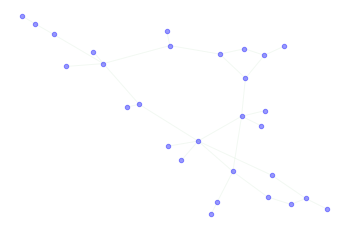

In [146]:


forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=20,
                        strongGravityMode=False,
                        gravity=0.5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_nx, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_nx, positions, node_size=20, with_labels=False, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(G_nx, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()


### Convert "positions" to "certesian"

In [147]:
certesian = [{'node':i,'x': float(positions[n][0]),'y': float(positions[n][1])}for i, n in enumerate(positions)]

### Apply "certesian" to NiceCX

In [148]:
ncx_from_x=ndex2.create_nice_cx_from_networkx(G_nx)

"""   Add attribute   """
for i, cluster in enumerate(v_community_greedy):
    ncx_from_x.set_node_attribute(i, str(cluster), cluster)

ncx_from_x.apply_style_from_network
ncx_from_x.set_opaque_aspect("cartesianLayout", certesian)

In [124]:
def BuildStyle(style_name, g, colors, community):
    # Prepare Defaults
    def_node_border_widh = {"visualProperty":"NODE_BORDER_WIDTH",
                           "value":0}
    def_node_transparency = {"visualProperty":"NODE_TRANSPARENCY",
                            "value":230}
    def_edge_transparency = {"visualProperty":"EDGE_TRANSPARENCY",
                            "value":120}
    def_edge_widh = {"visualProperty":"EDGE_WIDTH",
                    "value":2}
    def_network_background = {"visualProperty":"NETWORK_BACKGROUND_PAINT",
                             "value":"black"}
    
    default = [def_node_border_widh,
               def_node_transparency,
               def_edge_transparency,
               def_edge_widh,
               def_network_background]
    
    #Mappings
    mapping = []
    
    #Color mappings
    node_fill_color = {"mappingType":"passthrough",
                       "mappingColumns":colors,
                       "mappingColumnType":"String",
                       "visualProperty":"NODE_FILL_COLOR"}
    
    edge_color = {"mappingType":"passthrough",
                  "mappingColumn":colors,
                  "mappingColumnType":"String",
                  "visualProperty":"EDGE_STROKE_UNSELECTED_PAINT"}
    
    #Node Size Mapping
    min_betweenness = min(g.vs.betweenness())
    max_betweenness = max(g.vs.betweenness())
    
    point1 = {"value":min_betweenness,
              "lesser":"5.0",
              "equal":"5.0",
              "greater":"5.0"}
    
    point2 = {"value":max_betweenness,
              "lesser":"100.0",
              "equal":"100.0",
              "greater":"100.0"}
    
    node_size_continuous_points = [point1,point2]
    
    node_size = {"mappingType":"continuous",
                 "mappingColumn":"betweenness",
                 "mappingColumnType":"Double",
                 "visualProperty":"NODE_SIZE",
                 "points":node_size_continuous_points}
    
    edge_trans_point = {"value":1.0,
                        "lesser":"40",
                        "equal":"200",
                        "greater":"200"}
    edge_trans_continuous_points = [edge_trans_point]
    
    edge_trans = {"mappingType":"continuous",
                 "mappingColumn":community,
                 "mappingColumnType":"Double",
                 "visualProperty":"EDGE_TRANSPARENCY",
                 "points":edge_trans_continuous_points}
    
    mappings = [node_fill_color, edge_color, node_size, edge_trans]
    
    style = {"title":style_name, "default":defaults, "mapping":mappings}
    
    return style

In [125]:
BuildStyle('greedy',G_nx,,community)

SyntaxError: invalid syntax (<ipython-input-125-131463ab70cb>, line 1)

##  upload the network

In [72]:
my_account="agis"
my_password="agis"
my_server="http://public.ndexbio.org"

if my_account == 'enter your username here':
    print('*******WARNING!!!!*******')
    print('Please change the username and password before proceeding')
else:
    try:
        my_ndex=nc.Ndex2(my_server, my_account, my_password)
        my_ndex.update_status()
        print("Success.  Please continue.")
    except Exception as inst:
        print("Could not access account %s with password %s" % (my_account, my_password))
        print(inst.args)

Success.  Please continue.


In [73]:
upload_message=ncx_from_x.upload_to(my_server, my_account, my_password)
print(upload_message)

Generating CX
http://public.ndexbio.org/v2/network/c5a5db96-c608-11e9-8bb4-0ac135e8bacf


# Step 4: Send data to Cytoscape

In [149]:
HOST='192.168.1.47'
PORT=1234

#cy = cyrest.cyclient(host=HOST,port=PORT)
cy = cyrest.cyclient(host=HOST,port=PORT)

# Clear current session
cy.version()


apiVersion v1
cytoscapeVersion 3.7.1


Create a new session (Delete ALL data in current session)

In [150]:
cy.session.new()

Convert NetworkX object to CX

In [151]:
cxDict = ncx_from_x.to_cx()

with open('py3sample_nx.cx', 'w') as outfile:
    json.dump(cxDict, outfile)

Generating CX


In [152]:
url = 'http://'+HOST+':'+str(PORT)+'/v1/networks?format=cx'
response1 = requests.post(url, data=json.dumps(cxDict))
response1.text

'{"networkSUID":164}'